In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_compas_data(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    # Encode categorical variables
    categorical_columns = ['sex', 'age_cat', 'c_charge_degree']
    encoded_df = pd.get_dummies(use_df, columns=categorical_columns, drop_first=True)
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], drop_first=False)
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def create_aif_dataset(df, label_column, protected_attribute_names):
    """Create an AIF360 BinaryLabelDataset"""
    columns = [col for col in df.columns if col != label_column] + [label_column]
    df_copy = df[columns].copy()
    
    return BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_copy,
        label_names=[label_column],
        protected_attribute_names=protected_attribute_names
    )

def analyze_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups, model_name=""):
    """Analyze fairness metrics using AIF360"""
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print(f"\n=== Fairness Metrics for {model_name} ===")
    
    # Group Fairness Metrics
    print("\nGroup Fairness Metrics:")
    print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
    print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")
    
    # Equal Opportunity Metrics
    print("\nEqual Opportunity Metrics:")
    print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
    
    return metrics

def balanced_resample_compas(X, y, racial_column, race_values):
    """
    COMPAS-specific resampling with SMOTE, focusing on minority groups based on count
    """
    print(f"\nResampling for racial groups...")
    
    # Print original distribution
    print("\nOriginal distribution:")
    orig_dist = pd.DataFrame({
        'Race': race_values,
        'Target': y
    })
    print(pd.crosstab(orig_dist['Race'], orig_dist['Target']))
    
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    resampled_races = []
    
    # Get counts for each racial group
    group_counts = race_values.value_counts()
    max_count = group_counts.max()
    
    # Process each racial group
    for race in group_counts.index:
        print(race)
        mask = race_values == race
        X_group = X[mask]
        y_group = y[mask]
        
        # If this is a minority group (less samples than the majority group)
        # if group_counts[race] < max_count:
        #     # Calculate sampling ratio based on group size
        #     ratio = max_count / group_counts[race]
        #     # Cap the ratio to avoid extreme oversampling
        #     ratio = min(ratio, 2.0)  # You can adjust this cap
            
        #     sampling_strategy = {
        #         0: int(sum(y_group==0) * ratio),
        #         1: int(sum(y_group==1) * ratio)
        #     }
        #     print(f"\nRace {race} (count: {group_counts[race]}):")
        #     print(f"Sampling ratio: {ratio:.2f}")
        #     print(f"Target counts - Original: {dict(zip([0,1], np.bincount(y_group)))}") 
        #     print(f"Target counts - Target: {sampling_strategy}")
        # else:
        #     # For majority group, just balance the classes
        #     sampling_strategy = 'auto'
        #     print(f"\nRace {race} (majority group, count: {group_counts[race]}):")
        #     print("Using automatic class balancing")
        sampling_strategy = 'auto'
        
        try:
            pipeline = Pipeline([
                ('oversample', SMOTE(
                    sampling_strategy=sampling_strategy,
                    k_neighbors=min(5, len(X_group)-1),
                    random_state=42
                )),
                ('undersample', RandomUnderSampler(
                    sampling_strategy='auto',
                    random_state=42
                ))
            ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            resampled_races.extend([race] * len(y_res))
            
        except ValueError as e:
            print(f"Warning: Skipping race {race} due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
            resampled_races.extend([race] * len(y_group))
    
    # Print resampled distribution
    print("\nResampled distribution:")
    resampled_dist = pd.DataFrame({
        'Race': resampled_races,
        'Target': resampled_y
    })
    print(pd.crosstab(resampled_dist['Race'], resampled_dist['Target']))
    
    # Add race column back to resampled_X
    resampled_X['race'] = resampled_races
    
    # Reset indices to avoid duplicates
    resampled_X = resampled_X.reset_index(drop=True)
    resampled_y = resampled_y.reset_index(drop=True)
    
    return resampled_X, resampled_y, np.array(resampled_races)

def plot_distributions(X, y, X_resampled, y_resampled, racial_column):
    """Plot original and resampled distributions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    pd.crosstab(X[racial_column], y).plot(kind='bar', ax=ax1)
    ax1.set_title('Original Distribution')
    ax1.set_xlabel('Race')
    ax1.set_ylabel('Count')
    
    # Resampled distribution
    pd.crosstab(X_resampled[racial_column], y_resampled).plot(kind='bar', ax=ax2)
    ax2.set_title('Resampled Distribution')
    ax2.set_xlabel('Race')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_dict, X_test, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))
    
    for name, model in models_dict.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()


In [13]:
def balanced_resample_compas(X, y):
    """
    COMPAS-specific resampling with SMOTE, balancing all demographic groups
    """
    print("\nResampling for demographic groups...")
    
    # Get demographic columns
    race_cols = [col for col in X.columns if col.startswith('race_')]
    sex_cols = [col for col in X.columns if col.startswith('sex_')]
    age_cols = [col for col in X.columns if col.startswith('age_cat_')]
    
    # Create demographic labels
    X_demo = X.copy()
    X_demo['race'] = ''
    X_demo['sex'] = ''
    X_demo['age'] = ''
    
    for col in race_cols:
        X_demo.loc[X_demo[col] == 1, 'race'] = col.replace('race_', '')
    for col in sex_cols:
        X_demo.loc[X_demo[col] == 1, 'sex'] = col.replace('sex_', '')
    for col in age_cols:
        X_demo.loc[X_demo[col] == 1, 'age'] = col.replace('age_cat_', '')
    
    # Print original distributions
    print("\nOriginal distributions:")
    print("\nRace distribution:")
    print(pd.crosstab(X_demo['race'], y))
    print("\nSex distribution:")
    print(pd.crosstab(X_demo['sex'], y))
    print("\nAge distribution:")
    print(pd.crosstab(X_demo['age'], y))
    
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    
    # Get unique combinations of demographic groups
    demographic_groups = X_demo.groupby(['race', 'sex', 'age']).size().reset_index()
    print(f"\nTotal demographic combinations: {len(demographic_groups)}")
    
    # Find the maximum count across all demographic combinations
    group_counts = X_demo.groupby(['race', 'sex', 'age']).size()
    max_count = group_counts.max()
    
    # Process each demographic combination
    for _, group in demographic_groups.iterrows():
        mask = ((X_demo['race'] == group['race']) & 
                (X_demo['sex'] == group['sex']) & 
                (X_demo['age'] == group['age']))
        
        X_group = X[mask]
        y_group = y[mask]
        
        if len(X_group) == 0:
            continue
            
        current_count = len(X_group)
        print(f"\nProcessing group: Race={group['race']}, Sex={group['sex']}, Age={group['age']}")
        print(f"Original count: {current_count}")
        
        if current_count < max_count:
            # Calculate sampling ratio
            ratio = max_count / current_count
            ratio = min(ratio, 2.0)  # Cap the ratio to avoid extreme oversampling
            
            sampling_strategy = {
                0: int(sum(y_group==0) * ratio),
                1: int(sum(y_group==1) * ratio)
            }
            print(f"Sampling ratio: {ratio:.2f}")
            print(f"Target counts: {sampling_strategy}")
        else:
            sampling_strategy = 'auto'
            print("Using automatic class balancing")
        
        try:
            # Identify categorical features
            categorical_features = []
            for i, col in enumerate(X.columns):
                if col in race_cols + sex_cols + age_cols:
                    categorical_features.append(i)
            
            # Apply SMOTE with categorical features
            pipeline = Pipeline([
                ('oversample', SMOTENC(
                    categorical_features=categorical_features,
                    sampling_strategy=sampling_strategy,
                    k_neighbors=min(5, len(X_group)-1),
                    random_state=42
                )),
                ('undersample', RandomUnderSampler(
                    sampling_strategy='auto',
                    random_state=42
                ))
            ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            print(f"Resampled count: {len(X_res)}")
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            
        except ValueError as e:
            print(f"Warning: Skipping group due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
    
    # Reset indices
    resampled_X = resampled_X.reset_index(drop=True)
    resampled_y = resampled_y.reset_index(drop=True)
    
    # Print resampled distributions
    print("\nResampled distributions:")
    resampled_demo = resampled_X.copy()
    resampled_demo['race'] = ''
    resampled_demo['sex'] = ''
    resampled_demo['age'] = ''
    
    for col in race_cols:
        resampled_demo.loc[resampled_demo[col] == 1, 'race'] = col.replace('race_', '')
    for col in sex_cols:
        resampled_demo.loc[resampled_demo[col] == 1, 'sex'] = col.replace('sex_', '')
    for col in age_cols:
        resampled_demo.loc[resampled_demo[col] == 1, 'age'] = col.replace('age_cat_', '')
    
    print("\nRace distribution:")
    print(pd.crosstab(resampled_demo['race'], resampled_y))
    print("\nSex distribution:")
    print(pd.crosstab(resampled_demo['sex'], resampled_y))
    print("\nAge distribution:")
    print(pd.crosstab(resampled_demo['age'], resampled_y))
    
    return resampled_X, resampled_y

In [14]:
def plot_all_distributions(X, y, X_resampled, y_resampled):
    """Plot original and resampled distributions for race, age, and sex"""
    # Plot Race Distribution
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Original vs Resampled Distributions', fontsize=16)
    
    race_cols = [col for col in X.columns if col.startswith('race_')]
    X_race = pd.DataFrame({'Race': X[race_cols].idxmax(axis=1).str.replace('race_', ''),
                         'Target': y})
    X_resampled_race = pd.DataFrame({'Race': X_resampled[race_cols].idxmax(axis=1).str.replace('race_', ''),
                                   'Target': y_resampled})
    
    pd.crosstab(X_race['Race'], X_race['Target']).plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Original Race Distribution')
    axes[0,0].set_xlabel('Race')
    axes[0,0].set_ylabel('Count')

    pd.crosstab(X_resampled_race['Race'], X_resampled_race['Target']).plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Resampled Race Distribution')
    axes[0,1].set_xlabel('Race')
    axes[0,1].set_ylabel('Count')
    
    # Race Distribution
    # pd.crosstab(X_race['Race'], X_race['Target']).plot(kind='bar', ax=axes[0,0])
    # axes[0,0].set_title('Original Race Distribution')
    # axes[0,0].set_xlabel('Race')
    # axes[0,0].set_ylabel('Count')
    
    # pd.crosstab(X_resampled['race'], y_resampled).plot(kind='bar', ax=axes[0,1])
    # axes[0,1].set_title('Resampled Race Distribution')
    # axes[0,1].set_xlabel('Race')
    # axes[0,1].set_ylabel('Count')
    
    # Age Distribution
    age_cols = [col for col in X.columns if col.startswith('age_cat_')]
    X_age = pd.DataFrame({'Age': X[age_cols].idxmax(axis=1).str.replace('age_cat_', ''),
                         'Target': y})
    X_resampled_age = pd.DataFrame({'Age': X_resampled[age_cols].idxmax(axis=1).str.replace('age_cat_', ''),
                                   'Target': y_resampled})
    
    pd.crosstab(X_age['Age'], X_age['Target']).plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Original Age Distribution')
    axes[1,0].set_xlabel('Age Category')
    axes[1,0].set_ylabel('Count')
    
    pd.crosstab(X_resampled_age['Age'], X_resampled_age['Target']).plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Resampled Age Distribution')
    axes[1,1].set_xlabel('Age Category')
    axes[1,1].set_ylabel('Count')
    
    # Sex Distribution
    sex_cols = [col for col in X.columns if col.startswith('sex_')]
    X_sex = pd.DataFrame({'Sex': X[sex_cols].idxmax(axis=1).str.replace('sex_', ''),
                         'Target': y})
    X_resampled_sex = pd.DataFrame({'Sex': X_resampled[sex_cols].idxmax(axis=1).str.replace('sex_', ''),
                                   'Target': y_resampled})
    
    pd.crosstab(X_sex['Sex'], X_sex['Target']).plot(kind='bar', ax=axes[2,0])
    axes[2,0].set_title('Original Sex Distribution')
    axes[2,0].set_xlabel('Sex')
    axes[2,0].set_ylabel('Count')
    
    pd.crosstab(X_resampled_sex['Sex'], X_resampled_sex['Target']).plot(kind='bar', ax=axes[2,1])
    axes[2,1].set_title('Resampled Sex Distribution')
    axes[2,1].set_xlabel('Sex')
    axes[2,1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical distributions
    print("\nNumerical Distributions:")
    print("\nRace Distribution:")
    print("Original:")
    print(pd.crosstab(X['race'], y))
    print("\nResampled:")
    print(pd.crosstab(X_resampled['race'], y_resampled))
    
    print("\nAge Distribution:")
    print("Original:")
    print(pd.crosstab(X_age['Age'], X_age['Target']))
    print("\nResampled:")
    print(pd.crosstab(X_resampled_age['Age'], X_resampled_age['Target']))
    
    print("\nSex Distribution:")
    print("Original:")
    print(pd.crosstab(X_sex['Sex'], X_sex['Target']))
    print("\nResampled:")
    print(pd.crosstab(X_resampled_sex['Sex'], X_resampled_sex['Target']))

Loading and preparing COMPAS dataset...

Available racial groups: ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']

Training baseline model...

Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1153
           1       0.68      0.66      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


Testing SMOTE with racial resampling...

Resampling for demographic groups...

Original distributions:

Race distribution:
is_recid             0     1
race                        
African-American  1159  1425
Asian               17     9
Caucasian          981   733
Hispanic           270   184
Native American      6     9
Other              157    99

Sex distribution:
is_recid     0     1
sex                 
          

c:\Users\fsd_n\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (348) in class 0 will be larger than the number of samples in the majority class (class #0 -> 174)
  warnings.warn(
c:\Users\fsd_n\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (248) in class 1 will be larger than the number of samples in the majority class (class #0 -> 174)
  warnings.warn(
c:\Users\fsd_n\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (82) in class 0 will be larger than the number of samples in the majority class (class #0 -> 41)
  warnings.warn(
c:\Users\fsd_n\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (130) in class 0 will be larger than the number of samples in the majority class (class #0 -> 65)
  warnings.warn(
c:\


Processing group: Race=Hispanic, Sex=Male, Age=Greater than 45
Original count: 88
Sampling ratio: 2.00
Target counts: {0: 130, 1: 46}

Processing group: Race=Hispanic, Sex=Male, Age=Less than 25
Original count: 83
Sampling ratio: 2.00
Target counts: {0: 68, 1: 98}

Processing group: Race=Native American, Sex=, Age=
Original count: 2
Sampling ratio: 2.00
Target counts: {0: 0, 1: 4}

Processing group: Race=Native American, Sex=, Age=Greater than 45
Original count: 2
Sampling ratio: 2.00
Target counts: {0: 2, 1: 2}

Processing group: Race=Native American, Sex=Male, Age=
Original count: 8
Sampling ratio: 2.00
Target counts: {0: 10, 1: 6}

Processing group: Race=Native American, Sex=Male, Age=Greater than 45
Original count: 1
Sampling ratio: 2.00
Target counts: {0: 0, 1: 2}

Processing group: Race=Native American, Sex=Male, Age=Less than 25
Original count: 2
Sampling ratio: 2.00
Target counts: {0: 0, 1: 4}

Processing group: Race=Other, Sex=, Age=
Original count: 20
Sampling ratio: 2.00
Ta

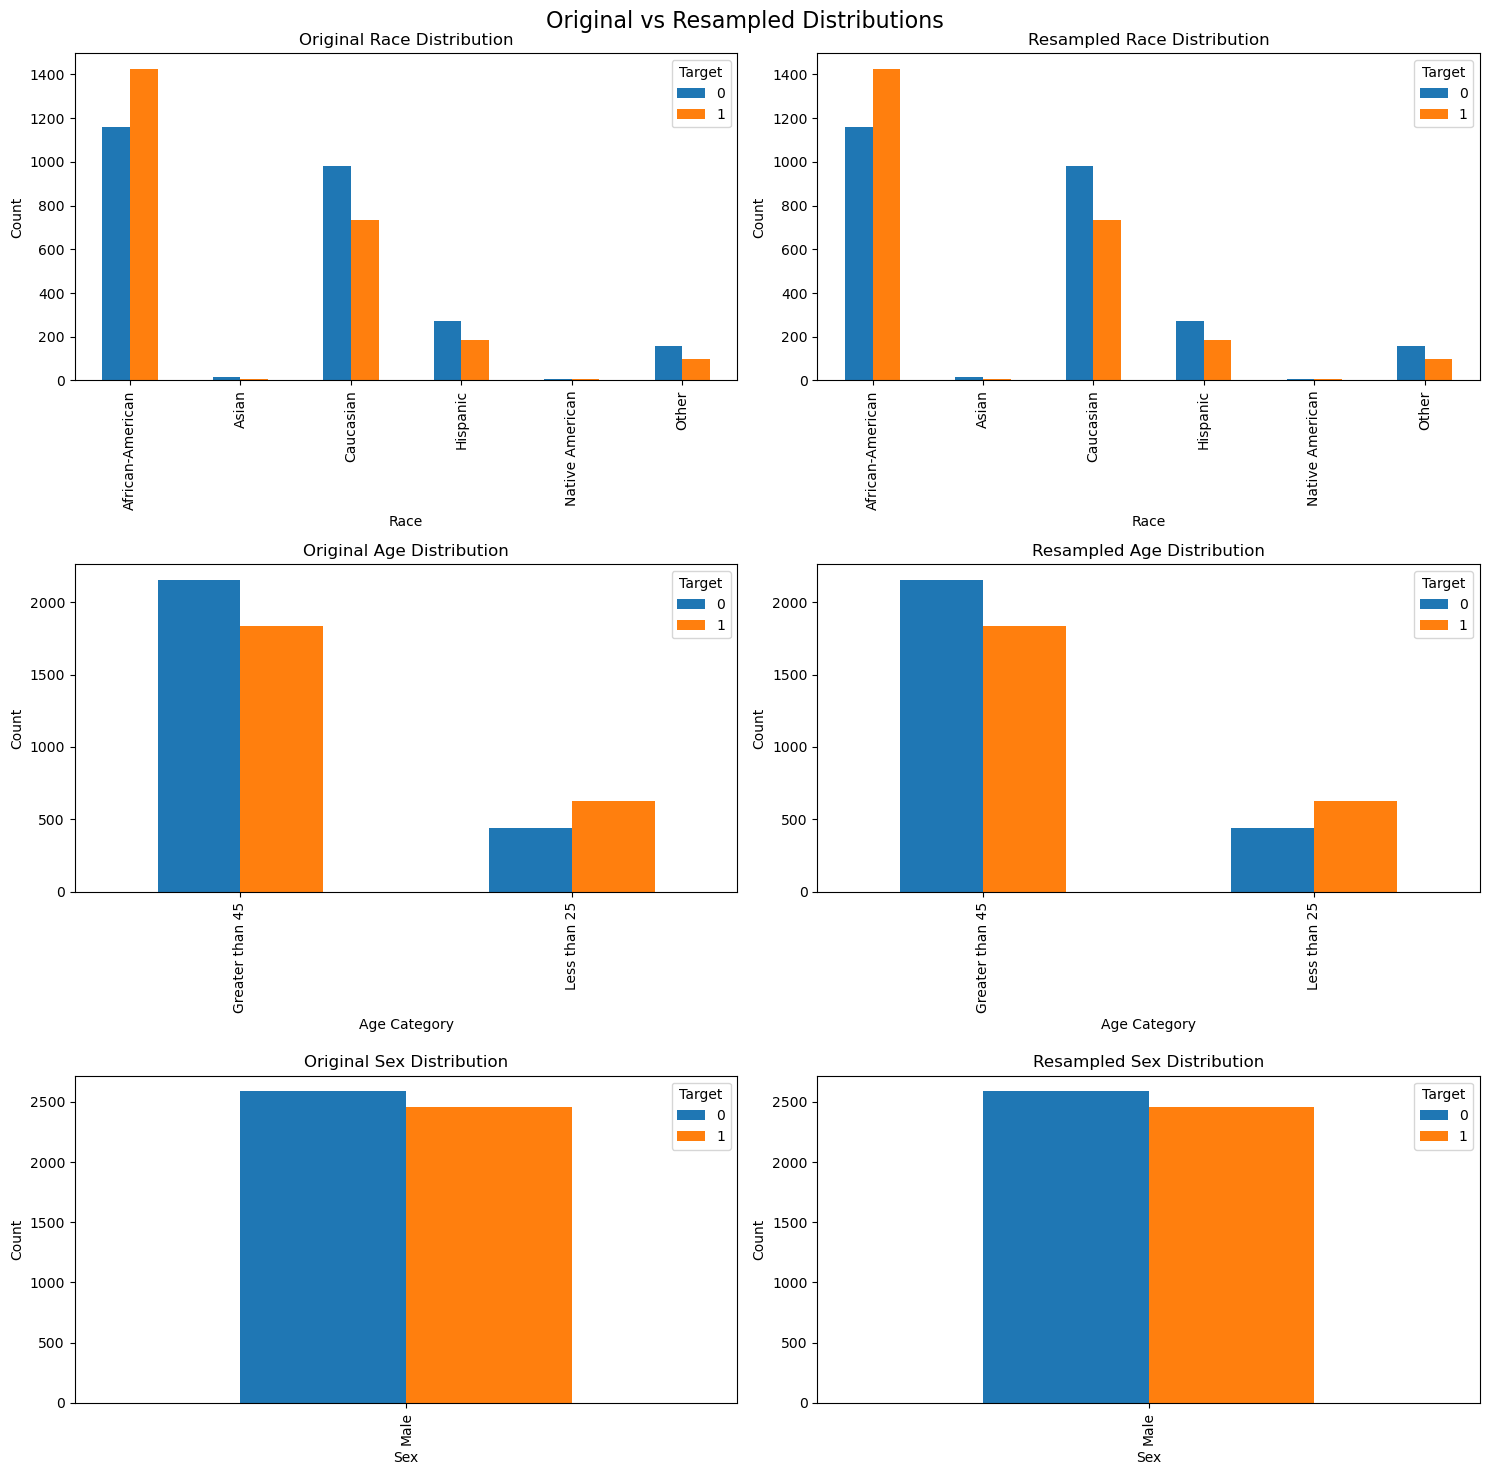


Numerical Distributions:

Race Distribution:
Original:
is_recid             0     1
race                        
African-American  1159  1425
Asian               17     9
Caucasian          981   733
Hispanic           270   184
Native American      6     9
Other              157    99

Resampled:
col_0                0     1
race                        
African-American  1159  1425
Asian               17     9
Caucasian          981   733
Hispanic           270   184
Native American      6     9
Other              157    99

Age Distribution:
Original:
Target              0     1
Age                        
Greater than 45  2153  1834
Less than 25      437   625

Resampled:
Target              0     1
Age                        
Greater than 45  2153  1834
Less than 25      437   625

Sex Distribution:
Original:
Target     0     1
Sex               
Male    2590  2459

Resampled:
Target     0     1
Sex               
Male    2590  2459

SMOTE Model Classification Report:
            

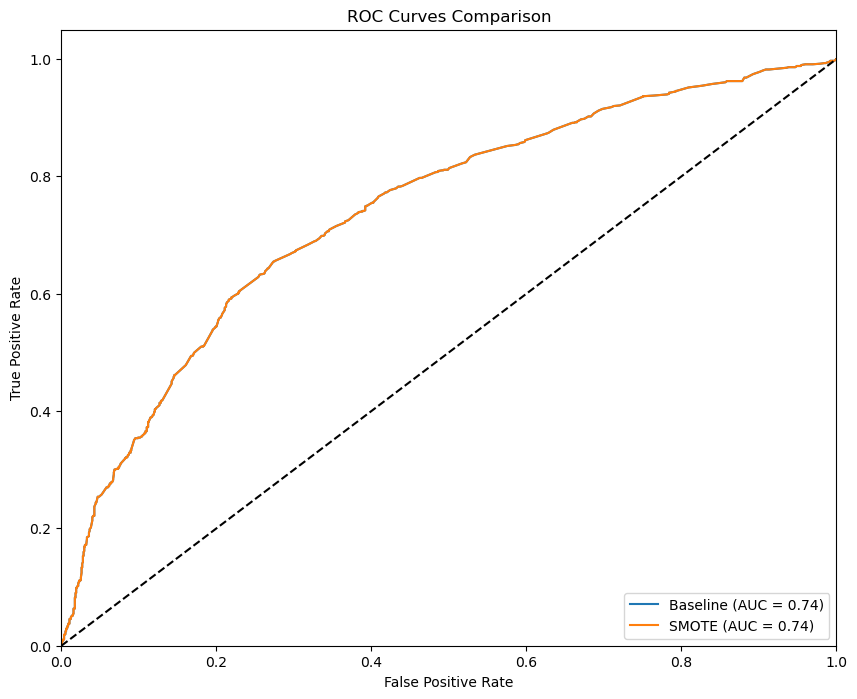

In [15]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

def prepare_compas_data_without_encoding(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    encoded_df = use_df.copy()
    # Encode categorical variables
    # categorical_columns = ['sex', 'age_cat', 'c_charge_degree']
    # encoded_df = pd.get_dummies(use_df, columns=categorical_columns, drop_first=True)
    
    # Encode race without dropping any category
    # encoded_df = pd.get_dummies(encoded_df, columns=['race'], drop_first=False)
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def test_smote_approaches():
    """Main function to test different SMOTE approaches"""
    # Initialize models dictionary
    models_dict = {}
    
    # Load and prepare data
    print("Loading and preparing COMPAS dataset...")
    X, y = prepare_compas_data('compas-scores-two-years.csv')
    
    # Get all race columns
    race_columns = [col for col in X.columns if col.startswith('race_')]
    print("\nAvailable racial groups:", race_columns)
    
    # Create a single race column for easier processing
    X['race'] = ''
    for col in race_columns:
        X.loc[X[col] == 1, 'race'] = col.replace('race_', '')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define protected groups for fairness metrics
    protected_groups = {
        'race': {
            'privileged': [{'race_Caucasian': 1}],
            'unprivileged': [{'race_African-American': 1}],
            'attributes': ['race_African-American', 'race_Caucasian']
        }
    }
    
    # Baseline model without SMOTE
    print("\nTraining baseline model...")
    baseline_model = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic'
    )
    # Drop 'race' column before training
    baseline_model.fit(X_train.drop('race', axis=1), y_train)
    models_dict['Baseline'] = baseline_model
    
    # Evaluate baseline model
    y_pred_baseline = baseline_model.predict(X_test.drop('race', axis=1))
    print("\nBaseline Model Classification Report:")
    print(classification_report(y_test, y_pred_baseline))
    
    # Test SMOTE with racial resampling
    print("\nTesting SMOTE with racial resampling...")
    
    # Apply SMOTE
    # X_resampled, y_resampled, _ = balanced_resample_compas(
    #     X_train.drop('race', axis=1), 
    #     y_train, 
    #     'race',
    #     X_train['race']  # Pass the race column separately
    # )
    # Apply SMOTE
    X_resampled, y_resampled = balanced_resample_compas(X_train, y_train)
    # print(X_train.head())
    # X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train.drop('race', axis=1), y_train)
    
    plot_all_distributions(X_train, y_train, X_resampled, y_resampled)
    
    # Plot distributions
    # plot_distributions(X_train, y_train, X_resampled, y_resampled, 'race')
    
    # Train model with resampled data
    smote_model = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic'
    )
    # Drop 'race' column before training
    smote_model.fit(X_resampled.drop('race', axis=1), y_resampled)
    models_dict['SMOTE'] = smote_model
    
    # Evaluate SMOTE model
    y_pred_smote = smote_model.predict(X_test.drop('race', axis=1))
    print("\nSMOTE Model Classification Report:")
    print(classification_report(y_test, y_pred_smote))
    
    # Create datasets for fairness analysis
    test_df = X_test.drop('race', axis=1).copy()  # Use one-hot encoded version
    test_df['label'] = y_test
    
    # Analyze fairness metrics for both models
    for model_name, model in models_dict.items():
        pred_df = X_test.drop('race', axis=1).copy()  # Use one-hot encoded version
        pred_df['label'] = model.predict(X_test.drop('race', axis=1))
        
        dataset_true = create_aif_dataset(test_df, 'label', protected_groups['race']['attributes'])
        dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['race']['attributes'])
        
        analyze_fairness_metrics(
            dataset_true,
            dataset_pred,
            protected_groups['race']['privileged'],
            protected_groups['race']['unprivileged'],
            model_name
        )
    
    # Plot ROC curves
    plot_roc_curves(models_dict, X_test.drop('race', axis=1), y_test)
    
    return models_dict  # Return the models dictionary for potential further use

if __name__ == "__main__":
    models = test_smote_approaches()

Loading and preparing COMPAS dataset...

Unique age categories: ['Greater than 45' '25 - 45' 'Less than 25']

Sex columns: ['sex_Male', 'sex_Female']
Age columns: ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']
Race columns: ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']

Original Distributions:

Feature columns for Race: ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']


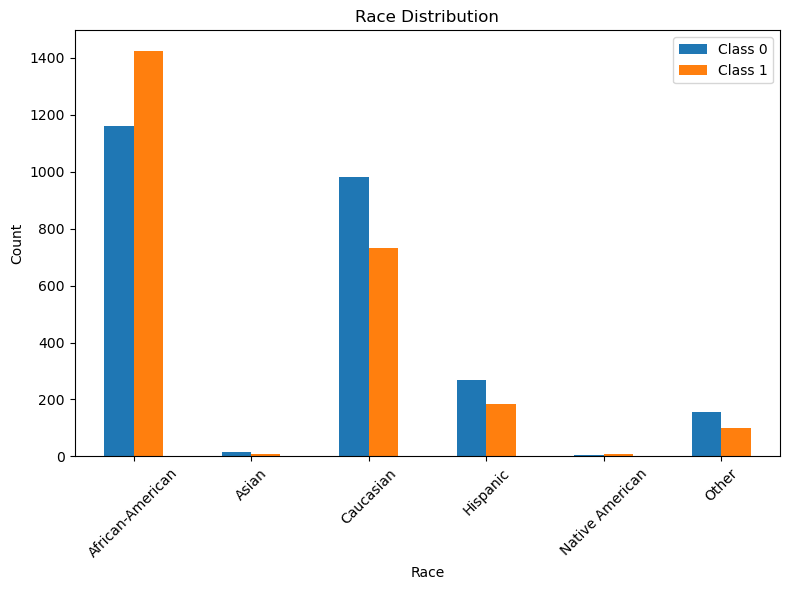


Race Distribution:
                     0     1
African-American  1159  1425
Asian               17     9
Caucasian          981   733
Hispanic           270   184
Native American      6     9
Other              157    99

Feature columns for Sex: ['sex_Male', 'sex_Female']


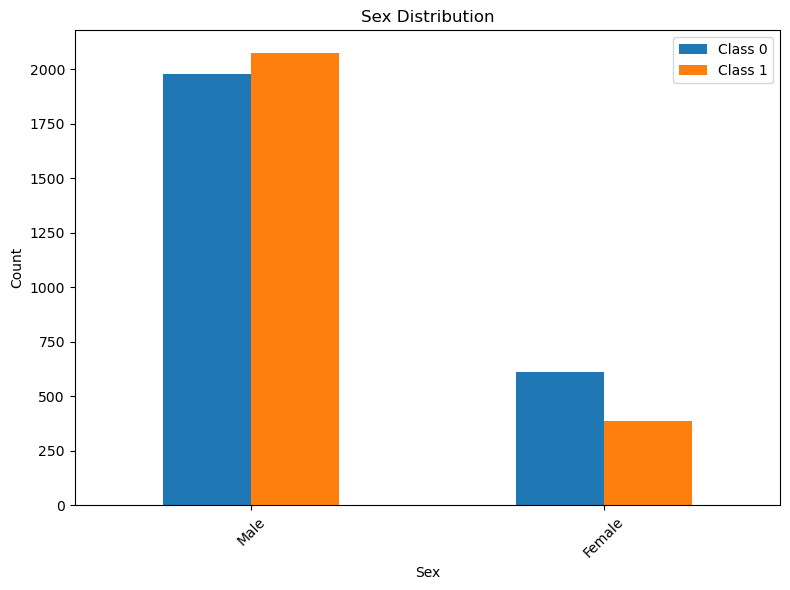


Sex Distribution:
           0     1
Male    1977  2074
Female   613   385

Feature columns for Age: ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']


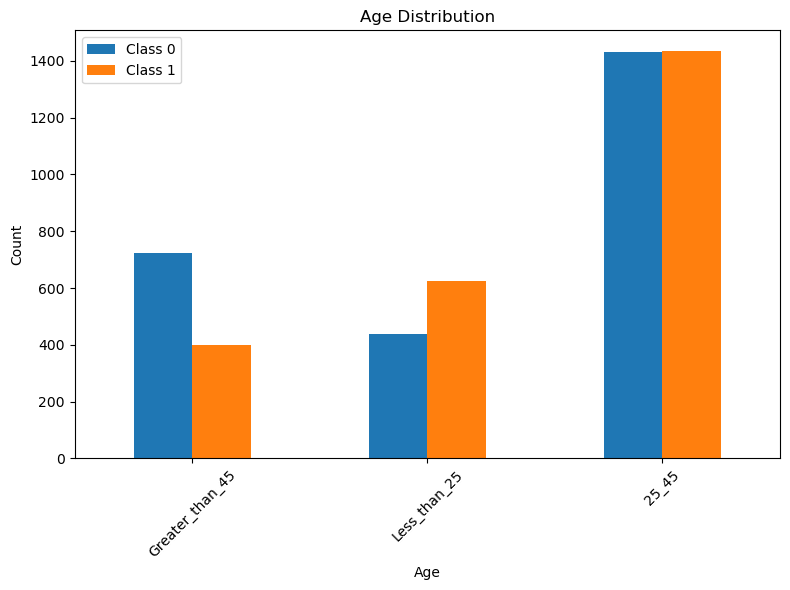


Age Distribution:
                    0     1
Greater_than_45   722   398
Less_than_25      437   625
25_45            1431  1436

Resampling by race...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
0    1425
1    1425
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    17
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
1    981
0    981
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
0    270
1    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    9
Name: is_recid, dtype: int64

Processing race_Other:
Original counts:
0    157
1     99
Na

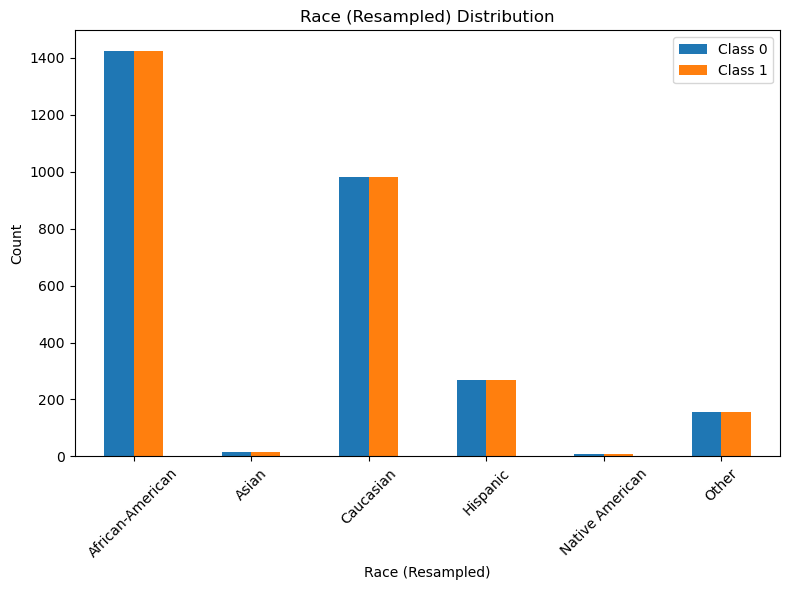


Race (Resampled) Distribution:
                     0     1
African-American  1425  1425
Asian               17    17
Caucasian          981   981
Hispanic           270   270
Native American      9     9
Other              157   157

Resampling by sex...

Processing sex_Male:
Original counts:
1    2074
0    1977
Name: is_recid, dtype: int64
Resampled counts:
1    2074
0    2074
Name: is_recid, dtype: int64

Processing sex_Female:
Original counts:
0    613
1    385
Name: is_recid, dtype: int64
Resampled counts:
0    613
1    613
Name: is_recid, dtype: int64

Feature columns for Sex (Resampled): ['sex_Male', 'sex_Female']


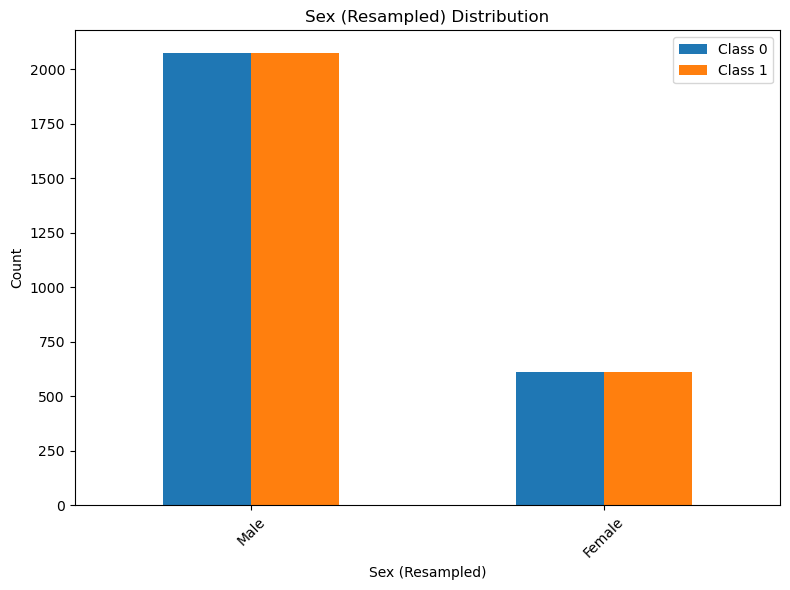


Sex (Resampled) Distribution:
           0     1
Male    2074  2074
Female   613   613

Resampling by age...

Processing age_cat_Greater_than_45:
Original counts:
0    722
1    398
Name: is_recid, dtype: int64
Resampled counts:
0    722
1    722
Name: is_recid, dtype: int64

Processing age_cat_Less_than_25:
Original counts:
1    625
0    437
Name: is_recid, dtype: int64
Resampled counts:
0    625
1    625
Name: is_recid, dtype: int64

Processing age_cat_25_45:
Original counts:
1    1436
0    1431
Name: is_recid, dtype: int64
Resampled counts:
1    1436
0    1436
Name: is_recid, dtype: int64

Feature columns for Age (Resampled): ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']


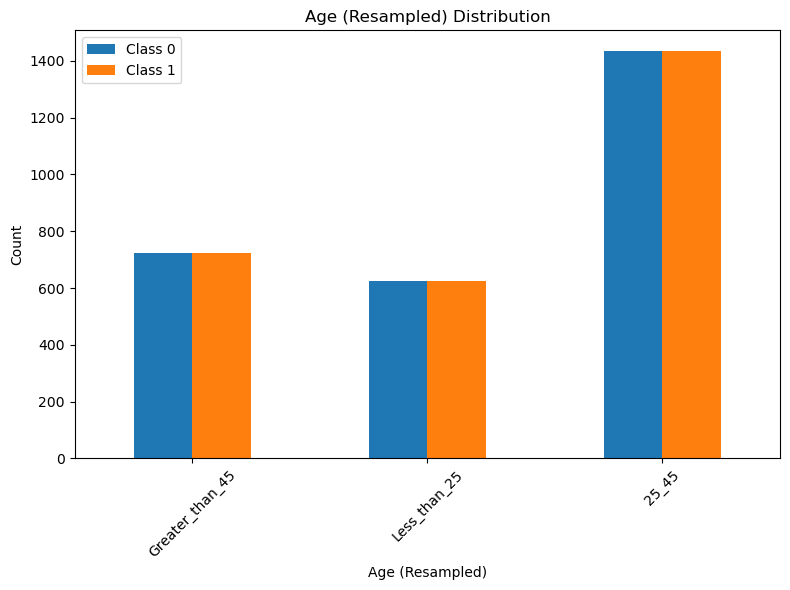


Age (Resampled) Distribution:
                    0     1
Greater_than_45   722   722
Less_than_25      625   625
25_45            1436  1436

Training Baseline model...

Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1153
           1       0.67      0.67      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Baseline - Race ===

Group Fairness Metrics:
Disparate Impact: 2.088
Statistical Parity Difference: 0.331

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.292
Average Odds Difference: 0.279

Privileged Group Metrics:
True Positive Rate: 0.500
False Positive Rate: 0.176
True Negative Rate: 0.824
False Negative Rate: 0.500
Positive Predictive Value: 0.649

Unprivileged Group Metrics:
True Positive Rate: 0.792
False Positive 

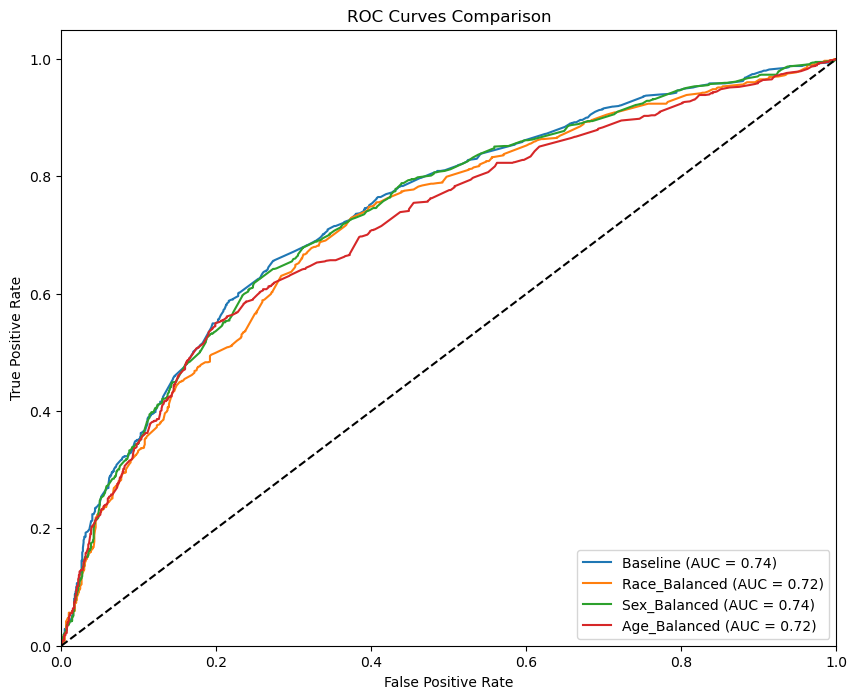

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set OpenBLAS thread count
os.environ['OMP_NUM_THREADS'] = '1'

def prepare_compas_data(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    print("\nUnique age categories:", use_df['age_cat'].unique())
    
    # Create binary columns for sex
    encoded_df = use_df.copy()
    encoded_df['sex_Male'] = (use_df['sex'] == 'Male').astype(int)
    encoded_df['sex_Female'] = (use_df['sex'] == 'Female').astype(int)
    
    # Create binary columns for age
    encoded_df['age_cat_Greater_than_45'] = (use_df['age_cat'] == 'Greater than 45').astype(int)
    encoded_df['age_cat_Less_than_25'] = (use_df['age_cat'] == 'Less than 25').astype(int)
    encoded_df['age_cat_25_45'] = (use_df['age_cat'] == '25 - 45').astype(int)
    
    # Encode charge degree
    encoded_df = pd.get_dummies(encoded_df, columns=['c_charge_degree'], prefix='charge')
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], prefix='race')
    
    # Drop original categorical columns
    encoded_df = encoded_df.drop(columns=['sex', 'age_cat'])
    
    # Print columns for verification
    print("\nSex columns:", [col for col in encoded_df.columns if col.startswith('sex_')])
    print("Age columns:", [col for col in encoded_df.columns if col.startswith('age_cat_')])
    print("Race columns:", [col for col in encoded_df.columns if col.startswith('race_')])
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def plot_distributions(X, y, title, feature_prefix):
    """Plot distribution for specific demographic feature"""
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    print(f"\nFeature columns for {title}:", feature_cols)
    
    # Create distribution DataFrame
    dist_df = pd.DataFrame(columns=[0, 1])
    for col in feature_cols:
        feature_name = col.replace(feature_prefix + '_', '')
        # For age, make the labels more readable
        if feature_prefix == 'age_cat':
            if feature_name == 'Less than 25':
                feature_name = '<25'
            elif feature_name == 'Greater than 45':
                feature_name = '>45'
            elif feature_name == '25 - 45':
                feature_name = '25-45'
                
        feature_data = X[X[col] == 1]
        counts = pd.crosstab(feature_data[col], y)
        
        # Handle cases where not all classes are present
        class_0_count = counts[0][1] if 0 in counts.columns else 0
        class_1_count = counts[1][1] if 1 in counts.columns else 0
        
        dist_df.loc[feature_name] = [class_0_count, class_1_count]
    
    # Plot
    ax = dist_df.plot(kind='bar', figsize=(8, 6))
    plt.title(f'{title} Distribution')
    plt.xlabel(title)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Class 0', 'Class 1'])
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title} Distribution:")
    print(dist_df)
    return dist_df

def create_aif_dataset(df, label_name, protected_attribute_names):
    """Create an AIF360 dataset"""
    return BinaryLabelDataset(
        df=df,
        label_names=[label_name],
        protected_attribute_names=protected_attribute_names
    )

def analyze_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups, model_name=""):
    """Analyze fairness metrics using AIF360"""
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print(f"\n=== Fairness Metrics for {model_name} ===")
    
    # Group Fairness Metrics
    print("\nGroup Fairness Metrics:")
    print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
    print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")
    
    # Equal Opportunity Metrics
    print("\nEqual Opportunity Metrics:")
    print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
    
    # Privileged Group Metrics
    print("\nPrivileged Group Metrics:")
    print(f"True Positive Rate: {metrics.true_positive_rate(privileged=True):.3f}")
    print(f"False Positive Rate: {metrics.false_positive_rate(privileged=True):.3f}")
    print(f"True Negative Rate: {metrics.true_negative_rate(privileged=True):.3f}")
    print(f"False Negative Rate: {metrics.false_negative_rate(privileged=True):.3f}")
    print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=True):.3f}")
    
    # Unprivileged Group Metrics
    print("\nUnprivileged Group Metrics:")
    print(f"True Positive Rate: {metrics.true_positive_rate(privileged=False):.3f}")
    print(f"False Positive Rate: {metrics.false_positive_rate(privileged=False):.3f}")
    print(f"True Negative Rate: {metrics.true_negative_rate(privileged=False):.3f}")
    print(f"False Negative Rate: {metrics.false_negative_rate(privileged=False):.3f}")
    print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=False):.3f}")
    
    return metrics

def resample_demographic(X, y, feature_prefix):
    """
    Resample data so that each group under the feature has equal numbers of 0s and 1s
    """
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    
    # Process each group
    for col in feature_cols:
        mask = X[col] == 1
        X_group = X[mask]
        y_group = y[mask]
        
        if len(X_group) == 0:
            continue
            
        print(f"\nProcessing {col}:")
        print(f"Original counts:")
        print(pd.Series(y_group).value_counts())
        
        # Get the count of the majority class
        target_count = max(sum(y_group == 0), sum(y_group == 1))
        
        # Set sampling strategy to make both classes equal to the majority class
        sampling_strategy = {0: target_count, 1: target_count}
        
        try:
            pipeline = Pipeline([
                ('oversample', SMOTE(
                    sampling_strategy=sampling_strategy,
                    k_neighbors=min(5, len(X_group)-1),
                    random_state=42
                ))
            ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            print(f"Resampled counts:")
            print(pd.Series(y_res).value_counts())
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            
        except ValueError as e:
            print(f"Warning: Skipping group due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True)

def test_smote_approaches():
    """Main function to test different SMOTE approaches"""
    # Load and prepare data
    print("Loading and preparing COMPAS dataset...")
    X, y = prepare_compas_data('compas-scores-two-years.csv')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Plot original distributions
    print("\nOriginal Distributions:")
    plot_distributions(X_train, y_train, "Race", "race")
    plot_distributions(X_train, y_train, "Sex", "sex")
    plot_distributions(X_train, y_train, "Age", "age_cat")
    
    # Resample by race
    print("\nResampling by race...")
    X_race, y_race = resample_demographic(X_train, y_train, "race")
    plot_distributions(X_race, y_race, "Race (Resampled)", "race")
    
    # Resample by sex
    print("\nResampling by sex...")
    X_sex, y_sex = resample_demographic(X_train, y_train, "sex")
    plot_distributions(X_sex, y_sex, "Sex (Resampled)", "sex")
    
    # Resample by age
    print("\nResampling by age...")
    X_age, y_age = resample_demographic(X_train, y_train, "age_cat")
    plot_distributions(X_age, y_age, "Age (Resampled)", "age_cat")
    
    # Train and evaluate models
    models = {
        'Baseline': X_train,
        'Race_Balanced': X_race,
        'Sex_Balanced': X_sex,
        'Age_Balanced': X_age
    }
    
    results = {}
    for name, X_resampled in models.items():
        print(f"\nTraining {name} model...")
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.1,
            n_estimators=200,
            objective='binary:logistic'
        )
        
        if name == 'Baseline':
            y_resampled = y_train
        elif name == 'Race_Balanced':
            y_resampled = y_race
        elif name == 'Sex_Balanced':
            y_resampled = y_sex
        else:
            y_resampled = y_age
            
        model.fit(X_resampled, y_resampled)
        
        # Evaluate
        y_pred = model.predict(X_test)
        print(f"\n{name} Model Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Fairness analysis
        test_df = X_test.copy()
        test_df['label'] = y_test
        pred_df = X_test.copy()
        pred_df['label'] = y_pred
        
        # Analyze fairness for race
        race_cols = [col for col in X.columns if col.startswith('race_')]
        dataset_true = create_aif_dataset(test_df, 'label', race_cols)
        dataset_pred = create_aif_dataset(pred_df, 'label', race_cols)
        
        analyze_fairness_metrics(
            dataset_true,
            dataset_pred,
            [{'race_Caucasian': 1}],
            [{'race_African-American': 1}],
            f"{name} - Race"
        )
        
        results[name] = model
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for name, model in results.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

if __name__ == "__main__":
    models = test_smote_approaches()

Loading and preparing COMPAS dataset...

Training regular XGBoost...

=== Regular XGBoost Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1153
           1       0.68      0.66      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Regular XGBoost - race ===

Group Fairness Metrics:
Disparate Impact: 1.993
Statistical Parity Difference: 0.301

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.276
Average Odds Difference: 0.248

Privileged Group Metrics:
True Positive Rate: 0.497
False Positive Rate: 0.176
True Negative Rate: 0.824
False Negative Rate: 0.503
Positive Predictive Value: 0.647

Unprivileged Group Metrics:
True Positive Rate: 0.773
False Positive Rate: 0.397
True Negative Rate: 0.603
False Negative Rate: 0.227
Positive

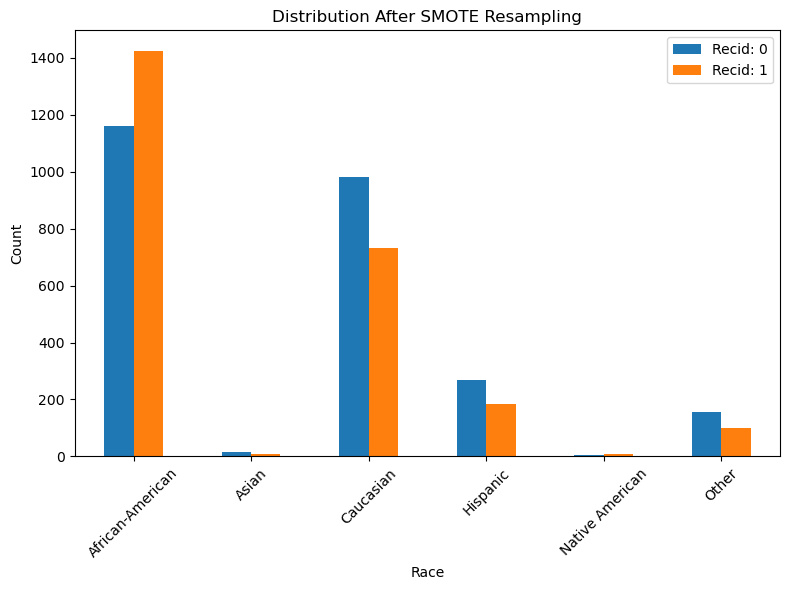


Original race Distribution:
                     0     1
African-American  1159  1425
Asian               17     9
Caucasian          981   733
Hispanic           270   184
Native American      6     9
Other              157    99

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
0    1425
1    1425
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    17
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
1    981
0    981
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
0    270
1    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    9
Name: is_rec

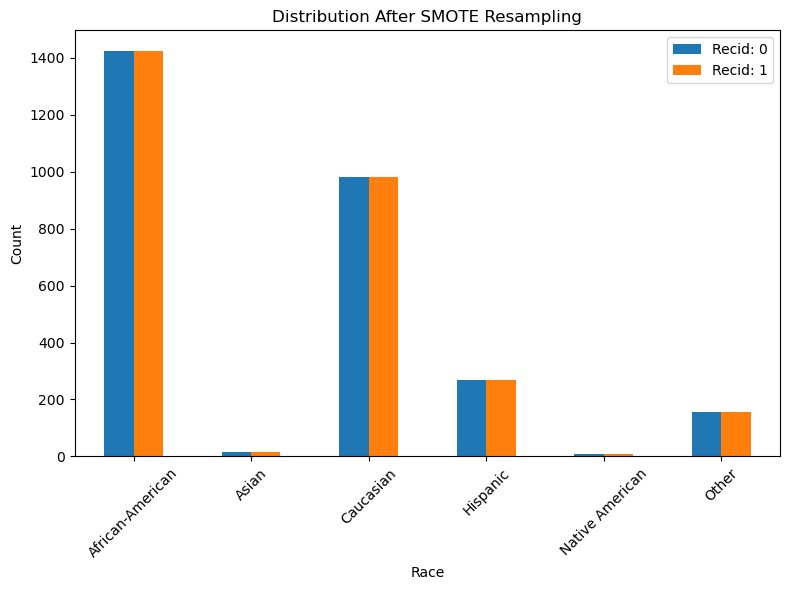


Resampled race Distribution:
                     0     1
African-American  1425  1425
Asian               17    17
Caucasian          981   981
Hispanic           270   270
Native American      9     9
Other              157   157

=== SMOTE XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1153
           1       0.65      0.67      0.66      1012

    accuracy                           0.68      2165
   macro avg       0.67      0.68      0.67      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for SMOTE XGBoost - race - race ===

Group Fairness Metrics:
Disparate Impact: 1.153
Statistical Parity Difference: 0.068

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.052
Average Odds Difference: 0.017

Privileged Group Metrics:
True Positive Rate: 0.637
False Positive Rate: 0.326
True Negative Rate: 0.674
False Negative Rate: 0.363
Po

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set OpenBLAS thread count
os.environ['OMP_NUM_THREADS'] = '1'

def prepare_compas_data(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    # Encode categorical variables
    categorical_columns = ['sex', 'age_cat', 'c_charge_degree']
    encoded_df = pd.get_dummies(use_df, columns=categorical_columns, drop_first=True)
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], drop_first=False)
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def create_aif_dataset(df, label_column, protected_attribute_names):
    """Create an AIF360 BinaryLabelDataset"""
    columns = [col for col in df.columns if col != label_column] + [label_column]
    df_copy = df[columns].copy()
    
    return BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_copy,
        label_names=[label_column],
        protected_attribute_names=protected_attribute_names
    )

def analyze_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups, model_name=""):
    """Analyze fairness metrics using AIF360"""
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print(f"\n=== Fairness Metrics for {model_name} ===")
    
    # Group Fairness Metrics
    print("\nGroup Fairness Metrics:")
    print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
    print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")
    
    # Equal Opportunity Metrics
    print("\nEqual Opportunity Metrics:")
    print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
    
    # Group-specific Metrics
    for group_type, group_metrics in [("Privileged", True), ("Unprivileged", False)]:
        print(f"\n{group_type} Group Metrics:")
        print(f"True Positive Rate: {metrics.true_positive_rate(privileged=group_metrics):.3f}")
        print(f"False Positive Rate: {metrics.false_positive_rate(privileged=group_metrics):.3f}")
        print(f"True Negative Rate: {metrics.true_negative_rate(privileged=group_metrics):.3f}")
        print(f"False Negative Rate: {metrics.false_negative_rate(privileged=group_metrics):.3f}")
        print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=group_metrics):.3f}")
    
    return metrics

def resample_demographic(X, y, feature_prefix):
    """Resample data so that each group under the feature has equal numbers of 0s and 1s"""
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    
    # Process each group
    for col in feature_cols:
        mask = X[col] == 1
        X_group = X[mask]
        y_group = y[mask]
        
        if len(X_group) == 0:
            continue
            
        print(f"\nProcessing {col}:")
        print(f"Original counts:")
        print(pd.Series(y_group).value_counts())
        
        # Get the count of the majority class
        target_count = max(sum(y_group == 0), sum(y_group == 1))
        
        # Set sampling strategy to make both classes equal to the majority class
        sampling_strategy = {0: target_count, 1: target_count}
        
        try:
            pipeline = Pipeline([
                ('oversample', SMOTE(
                    sampling_strategy=sampling_strategy,
                    k_neighbors=min(5, len(X_group)-1),
                    random_state=42
                ))
            ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            print(f"Resampled counts:")
            print(pd.Series(y_res).value_counts())
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            
        except ValueError as e:
            print(f"Warning: Skipping group due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True)

def plot_distributions(X, y, title, feature_prefix):
    """Plot distribution for specific demographic feature"""
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    print(f"\nFeature columns for {title}:", feature_cols)
    
    # Create distribution DataFrame
    dist_df = pd.DataFrame(columns=[0, 1])
    for col in feature_cols:
        feature_name = col.replace(feature_prefix + '_', '')
        # For age, make the labels more readable
        if feature_prefix == 'age_cat':
            if feature_name == 'Less than 25':
                feature_name = '<25'
            elif feature_name == 'Greater than 45':
                feature_name = '>45'
            elif feature_name == '25 - 45':
                feature_name = '25-45'
                
        feature_data = X[X[col] == 1]
        counts = pd.crosstab(feature_data[col], y)
        
        # Handle cases where not all classes are present
        class_0_count = counts[0][1] if 0 in counts.columns else 0
        class_1_count = counts[1][1] if 1 in counts.columns else 0
        
        dist_df.loc[feature_name] = [class_0_count, class_1_count]
    
    # Plot99998
    ax = dist_df.plot(kind='bar', figsize=(8, 6))
    plt.title(f'Distribution After SMOTE Resampling')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Recid: 0', 'Recid: 1'])
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title} Distribution:")
    print(dist_df)
    return dist_df

def balanced_resample_compas(X, y, protected_attribute):
    """COMPAS-specific resampling with SMOTE, focusing on protected attributes"""
    print(f"\nResampling for {protected_attribute}...")
    
    # Plot original distribution
    plot_distributions(X, y, f"Original {protected_attribute}", protected_attribute)
    
    # Perform resampling
    X_resampled, y_resampled = resample_demographic(X, y, protected_attribute)
    
    # Plot resampled distribution
    plot_distributions(X_resampled, y_resampled, f"Resampled {protected_attribute}", protected_attribute)
    # plot_distributions(X_resampled, y_resampled, f"After SMOTE Resampling ")
    
    return X_resampled, y_resampled, None

def evaluate_model(model_name, model, X_test, y_test, protected_groups):
    """Evaluate model performance and fairness"""
    predictions = model.predict(X_test)
    
    print(f"\n=== {model_name} Performance ===")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    
    # Create datasets for fairness analysis
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = predictions
    
    for attr_type, group_info in protected_groups.items():
        dataset_true = create_aif_dataset(test_df, 'label', group_info['attributes'])
        dataset_pred = create_aif_dataset(pred_df, 'label', group_info['attributes'])
        
        analyze_fairness_metrics(
            dataset_true,
            dataset_pred,
            group_info['privileged'],
            group_info['unprivileged'],
            f"{model_name} - {attr_type}"
        )

def plot_roc_curves(models_dict, X_test, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))
    
    for name, model in models_dict.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

def main():
    # Load and prepare data
    print("Loading and preparing COMPAS dataset...")
    X, y = prepare_compas_data('compas-scores-two-years.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define protected groups
    protected_groups = {
        'race': {
            'privileged': [{'race_Caucasian': 1}],
            'unprivileged': [{'race_African-American': 1}],
            'attributes': ['race_African-American', 'race_Caucasian']
        },
        'sex': {
            'privileged': [{'sex_Male': 0}],
            'unprivileged': [{'sex_Male': 1}],
            'attributes': ['sex_Male']
        },
        'age': {
            'privileged': [{'age_cat_Greater than 45': 1}],
            'unprivileged': [{'age_cat_Less than 25': 1}],
            'attributes': ['age_cat_Greater than 45', 'age_cat_Less than 25']
        }
    }

    # Train regular XGBoost
    print("\nTraining regular XGBoost...")
    regular_xgb = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic'
    )
    regular_xgb.fit(X_train, y_train)
    evaluate_model("Regular XGBoost", regular_xgb, X_test, y_test, protected_groups)

    # Train SMOTE-based models for each protected attribute
    models = {'Regular': regular_xgb}
    
    # for attr in ['race', 'sex', 'age_cat']:
    for attr in ['race']:
        print(f"\nTraining SMOTE-based XGBoost for {attr}...")
        X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, attr)
        smote_xgb = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.1,
            n_estimators=200,
            objective='binary:logistic'
        )
        smote_xgb.fit(X_resampled, y_resampled)
        evaluate_model(f"SMOTE XGBoost - {attr}", smote_xgb, X_test, y_test, protected_groups)
        models[f'SMOTE_{attr}'] = smote_xgb

    # Plot ROC curves
    # plot_roc_curves(models, X_test, y_test)

if __name__ == "__main__":
    main()

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set OpenBLAS thread count
os.environ['OMP_NUM_THREADS'] = '1'

Loading and preparing COMPAS dataset...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
1    1425
0    1213
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    16
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
0    981
1    958
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
1    287
0    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    7
Name: is_recid, dtype: int64

Processing race_Other:
Original counts:
0    157
1     99
Name: is_recid, dtype: int64
Resampled counts:
0    157
1    150
Name: is_recid, dtype: int64


<Figure size 800x600 with 0 Axes>

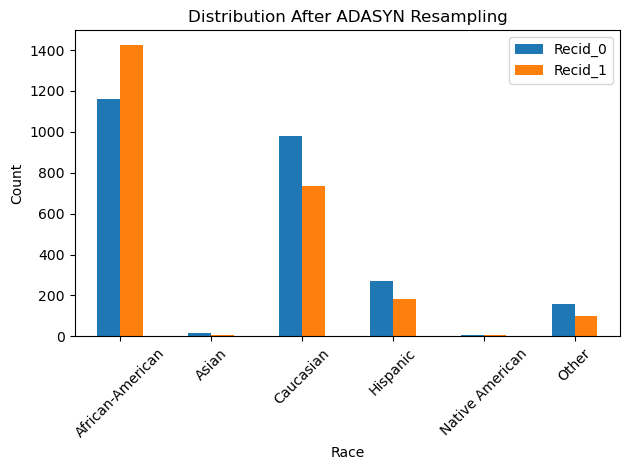

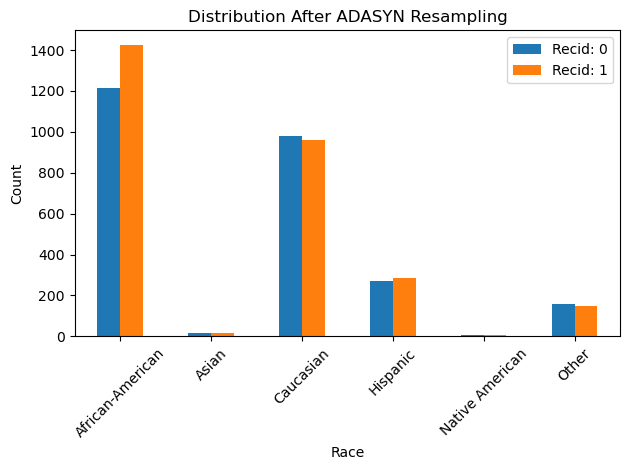


Race Distribution:

Original:
               Race  Recid_0  Recid_1
0  African-American     1159     1425
1             Asian       17        9
2         Caucasian      981      733
3          Hispanic      270      184
4   Native American        6        9
5             Other      157       99

Resampled:
               Race  Recid_0  Recid_1
0  African-American     1213     1425
1             Asian       17       16
2         Caucasian      981      958
3          Hispanic      270      287
4   Native American        7        9
5             Other      157      150


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


def train_adasyn_model(X_train, y_train, attr, random_state=42):
    """
    Train XGBoost with ADASYN sampling for a specific protected attribute
    """
    # Create combined labels that consider both protected attribute and target
    protected = X_train[attr].values
    combined_labels = protected * 2 + y_train
    
    # Plot original distributions
    print("\nOriginal Distributions:")
    plot_distributions(protected, y_train, "Original Data")
    
    try:
        # Initialize ADASYN with careful parameter tuning
        adasyn = ADASYN(
            sampling_strategy='minority',
            random_state=random_state,
            n_neighbors=min(5, pd.Series(combined_labels).value_counts().min() - 1)
        )
        
        # Perform ADASYN sampling on the combined labels
        X_resampled, combined_labels_resampled = adasyn.fit_resample(X_train, combined_labels)
        
        # Convert back to separate protected attribute and target
        protected_resampled = (combined_labels_resampled >= 2).astype(int)
        y_resampled = combined_labels_resampled % 2
        
        # Plot resampled distributions
        print("\nResampled Distributions:")
        plot_distributions(protected_resampled, y_resampled, "Resampled Data")
        
        # Print numerical distributions
        print("\nDetailed Distribution Statistics:")
        print("\nOriginal distribution:")
        print(pd.DataFrame({'protected': protected, 'target': y_train})
              .groupby(['protected', 'target']).size().unstack(fill_value=0))
        print("\nResampled distribution:")
        print(pd.DataFrame({'protected': protected_resampled, 'target': y_resampled})
              .groupby(['protected', 'target']).size().unstack(fill_value=0))
        
    except ValueError as e:
        print(f"\nADASYN failed: {e}")
        print("Falling back to original data...")
        X_resampled, y_resampled, protected_resampled = X_train, y_train, protected
    
    # Train XGBoost on resampled data
    adasyn_xgb = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic',
        random_state=random_state
    )
    adasyn_xgb.fit(X_resampled, y_resampled)
    
    return adasyn_xgb, X_resampled, y_resampled


def resample_demographic(X, y, feature_prefix):
    """Resample data so that each group under the feature has equal numbers of 0s and 1s"""
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    
    # Process each group
    for col in feature_cols:
        mask = X[col] == 1
        X_group = X[mask]
        y_group = y[mask]
        
        if len(X_group) == 0:
            continue
            
        print(f"\nProcessing {col}:")
        print(f"Original counts:")
        print(pd.Series(y_group).value_counts())
        
        # Get the count of the majority class
        target_count = max(sum(y_group == 0), sum(y_group == 1))
        
        # Set sampling strategy to make both classes equal to the majority class
        sampling_strategy = {0: target_count, 1: target_count}
        
        try:
            pipeline = Pipeline([
                ('oversample', ADASYN(
                    sampling_strategy=sampling_strategy,
                    random_state=42
                ))
            ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            print(f"Resampled counts:")
            print(pd.Series(y_res).value_counts())
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            
        except ValueError as e:
            print(f"Warning: Skipping group due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True)

def plot_race_distributions(X_train, y_train, X_resampled, y_resampled):
    """Plot original and resampled distributions for race as separate plots"""
    # Get race columns
    race_cols = [col for col in X_train.columns if col.startswith('race_')]
    
    # Plot Original Distribution
    plt.figure(figsize=(8, 6))
    original_counts = []
    for race_col in race_cols:
        race_data = X_train[X_train[race_col] == 1]
        counts = pd.Series(y_train[race_data.index]).value_counts()
        original_counts.append({
            'Race': race_col.replace('race_', ''),
            'Recid_0': counts.get(0, 0),
            'Recid_1': counts.get(1, 0)
        })
    
    df_original = pd.DataFrame(original_counts)
    df_original.plot(x='Race', y=['Recid_0', 'Recid_1'], kind='bar')
    plt.title('Distribution After ADASYN Resampling')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Resampled Distribution

    resampled_counts = []
    for race_col in race_cols:
        race_data = X_resampled[X_resampled[race_col] == 1]
        counts = pd.Series(y_resampled[race_data.index]).value_counts()
        resampled_counts.append({
            'Race': race_col.replace('race_', ''),
            'Recid_0': counts.get(0, 0),
            'Recid_1': counts.get(1, 0)
        })
    
    df_resampled = pd.DataFrame(resampled_counts)
    df_resampled.plot(x='Race', y=['Recid_0', 'Recid_1'], kind='bar')
    plt.title('Distribution After ADASYN Resampling')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Recid: 0', 'Recid: 1'])
    plt.tight_layout() #1112
    plt.show()

    
    # Print numerical distributions
    print("\nRace Distribution:")
    print("\nOriginal:")
    print(df_original)
    print("\nResampled:")
    print(df_resampled)

def main():
    # Load and prepare data
    print("Loading and preparing COMPAS dataset...")
    X, y = prepare_compas_data('compas-scores-two-years.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
    # Perform ADASYN sampling on the combined labels
    X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race')
    
    # Plot race distributions
    plot_race_distributions(X_train, y_train, X_resampled, y_resampled)

if __name__ == "__main__":
    main()

# def main():
#     # Load and prepare data
#     print("Loading and preparing COMPAS dataset...")
#     X, y = prepare_compas_data('compas-scores-two-years.csv')
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
#     # Perform ADASYN sampling on the combined labels
#     X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race')
#     plot_all_distributions(X_train, y_train, X_resampled, y_resampled)

# if __name__ == "__main__":
#     main()

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import seaborn as sns

def prepare_compas_data(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    # Create binary columns for sex
    encoded_df = use_df.copy()
    encoded_df['sex_Male'] = (use_df['sex'] == 'Male').astype(int)
    
    # Create binary columns for age
    encoded_df['age_cat_Greater_than_45'] = (use_df['age_cat'] == 'Greater than 45').astype(int)
    encoded_df['age_cat_Less_than_25'] = (use_df['age_cat'] == 'Less than 25').astype(int)
    encoded_df['age_cat_25_45'] = (use_df['age_cat'] == '25 - 45').astype(int)
    
    # Encode charge degree
    encoded_df = pd.get_dummies(encoded_df, columns=['c_charge_degree'], prefix='charge')
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], prefix='race')
    
    # Drop original categorical columns
    encoded_df = encoded_df.drop(columns=['sex', 'age_cat'])
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def compare_race_distributions(X_original, y_original, X_smote, y_smote, X_adasyn, y_adasyn):
    """Compare race distributions across original, SMOTE, and ADASYN datasets"""
    plt.figure(figsize=(15, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    race_cols = [col for col in X_original.columns if col.startswith('race_')]
    original_counts = []
    for race_col in race_cols:
        race_data = X_original[X_original[race_col] == 1]
        counts = pd.Series(y_original[race_data.index]).value_counts()
        original_counts.append({
            'Race': race_col.replace('race_', ''),
            'Recid_0': counts.get(0, 0),
            'Recid_1': counts.get(1, 0)
        })
    
    df_original = pd.DataFrame(original_counts)
    df_original.plot(x='Race', y=['Recid_0', 'Recid_1'], kind='bar', ax=plt.gca())
    plt.title('Original Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    
    # SMOTE distribution
    plt.subplot(1, 3, 2)
    smote_counts = []
    for race_col in race_cols:
        race_data = X_smote[X_smote[race_col] == 1]
        counts = pd.Series(y_smote[race_data.index]).value_counts()
        smote_counts.append({
            'Race': race_col.replace('race_', ''),
            'Recid_0': counts.get(0, 0),
            'Recid_1': counts.get(1, 0)
        })
    
    df_smote = pd.DataFrame(smote_counts)
    df_smote.plot(x='Race', y=['Recid_0', 'Recid_1'], kind='bar', ax=plt.gca())
    plt.title('After SMOTE')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    
    # ADASYN distribution
    plt.subplot(1, 3, 3)
    adasyn_counts = []
    for race_col in race_cols:
        race_data = X_adasyn[X_adasyn[race_col] == 1]
        counts = pd.Series(y_adasyn[race_data.index]).value_counts()
        adasyn_counts.append({
            'Race': race_col.replace('race_', ''),
            'Recid_0': counts.get(0, 0),
            'Recid_1': counts.get(1, 0)
        })
    
    df_adasyn = pd.DataFrame(adasyn_counts)
    df_adasyn.plot(x='Race', y=['Recid_0', 'Recid_1'], kind='bar', ax=plt.gca())
    plt.title('After ADASYN')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical summaries
    print("\nOriginal Distribution:")
    print(df_original)
    print("\nAfter SMOTE:")
    print(df_smote)
    print("\nAfter ADASYN:")
    print(df_adasyn)

def main():
    # Load and prepare data
    print("Loading and preparing COMPAS dataset...")
    X, y = prepare_compas_data('compas-scores-two-years.csv')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Print original class distribution
    print("\nOriginal class distribution:")
    print(Counter(y_train))
    
    # Apply SMOTE
    print("\nApplying SMOTE...")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
    print("SMOTE class distribution:")
    print(Counter(y_resampled_smote))
    
    # Apply ADASYN with modified parameters
    print("\nApplying ADASYN...")
    adasyn = ADASYN(
        sampling_strategy='minority',  # or you can use a float value like 0.8
        n_neighbors=5,
        random_state=42
    )
    X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
    print("ADASYN class distribution:")
    print(Counter(y_resampled_adasyn))
    
    # Compare distributions
    compare_race_distributions(
        X_train, y_train,
        X_resampled_smote, y_resampled_smote,
        X_resampled_adasyn, y_resampled_adasyn
    )

if __name__ == "__main__":
    main()

Loading and preparing COMPAS dataset...

Original class distribution:
Counter({0: 2590, 1: 2459})

Applying SMOTE...
SMOTE class distribution:
Counter({1: 2590, 0: 2590})

Applying ADASYN...


ValueError: No samples will be generated with the provided ratio settings.